## 0. Постановка задачи

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит **задача проанализировать ВВП африканской страны Гана**. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

**Задания проекта:**<br>
1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.
2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.<br>
Пример: train_df.spx.rolling(window=2).mean().<br>
Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.
3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.<br>
**Примечание.** <br>
Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.<br>
Параметры p и q выберите по коррелограммам ACF и PACF.<br>
**Примечание.** <br>
Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.<br>
4. Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).
Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
6. Сделайте выводы по полученным результатам.

## 1. Знакомство с данными

**1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.**

In [8]:
# Установим нужную версию numpy
!pip install numpy==1.23.5

# Установим совместимые версии pmdarima и prophet
!pip install pmdarima prophet

In [9]:
# Подключаем библиотеки
from google.colab import drive # для загрузки данных из Google Диска
import pandas as pd # для работы с табличными данными
import numpy as np # для работы с массивами и численными вычислениями
from plotly.subplots import make_subplots # для создания сложных графиков с подграфиками
import plotly.graph_objects as go # для кастомных графиков
import plotly.express as px # для простых и быстрых визуализаций
from statsmodels.tsa.stattools import adfuller # импортируем функцию теста Дикки-Фуллера для проверки стационарности временного ряда
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # автокорреляции и частичные автокорреляции
import statsmodels.graphics.tsaplots as sgt # дополнительные графики временных рядов
from statsmodels.tsa.arima.model import ARIMA # ARIMA-модель
import pmdarima as pm # автоматический подбор параметров ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error  # метрики качества моделей MAPE и MSE
from statsmodels.tsa.seasonal import seasonal_decompose # разложение временного ряда на тренд, сезонность и остаток
from matplotlib import pyplot as plt # классическая библиотека визуализации
from sklearn.linear_model import LinearRegression # линейная регрессия
from prophet import Prophet # модель прогнозирования временных рядов от Facebook
import plotly.io as pio # настройка отображения графиков Plotly в виде изображений
pio.renderers.default = 'png'


In [10]:
# Монтируем Google Диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Загружаем данные
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Andrew_learning/ghana_gdp.csv')
df.head()

,year,GDP (current US$)
0,1960-01-01,1.217087e+09
1,1961-01-01,0.000000e+00
2,1962-01-01,1.382353e+09
3,1963-01-01,1.540616e+09
4,1964-01-01,1.731092e+09


In [12]:
df.tail()

,year,GDP (current US$)
57,2017-01-01,6.040638e+10
58,2018-01-01,6.729928e+10
59,2019-01-01,6.833754e+10
60,2020-01-01,7.004320e+10
61,2021-01-01,7.759428e+10


In [13]:
# Преобразуем колонку 'year' в datetime и установим её как индекс
df['year'] = pd.to_datetime(df['year'])
df.set_index('year', inplace=True)
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [14]:
# Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


In [15]:
# Проверка отсутствующих значений
pd.isna(df).sum()[pd.isna(df).sum() > 0]

,0


**Выводы:**<br>
 Итак, данные успешно загружены и состоят из 62-х строк и 2-х столбцов: <br>
- year - год, начиная с 1960-го;
- GDP - значение ВВП Ганы в текущих долларах США. <br>

Также стоит отметить, что значение ВВП за 1961 год равно 0, что является ошибочным или пропуском данных, т.к ВВП не может быть нулевым. Следовательно необходимо в столбце 'GDP (current US$)' выполнить замену всех значений 0 на NaN.

In [16]:
# Заменяем все значения 0 в столбце 'GDP (current US$)' на NaN
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)

In [17]:
# Повтроно выполним проверку отсутствующих значений
pd.isna(df).sum()[pd.isna(df).sum() > 0]

,0
GDP (current US$),1


Для заполнения пропусков выполним интерполяцию с использованием метода interpolate()

In [18]:
# Заполняем пропущенные значения в столбце 'GDP (current US$)' с помощью линейной интерполяции
df['GDP (current US$)'] = df['GDP (current US$)'].interpolate(method='linear')
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


**Выводы:**<br>
В результате выполнения линейной интерполяции был заполнен пропуск за 1961 г.

 Визуализируем исходный временной ряд и сделаем первичные выводы о присутствии компонента тренда и сезонности в ряде

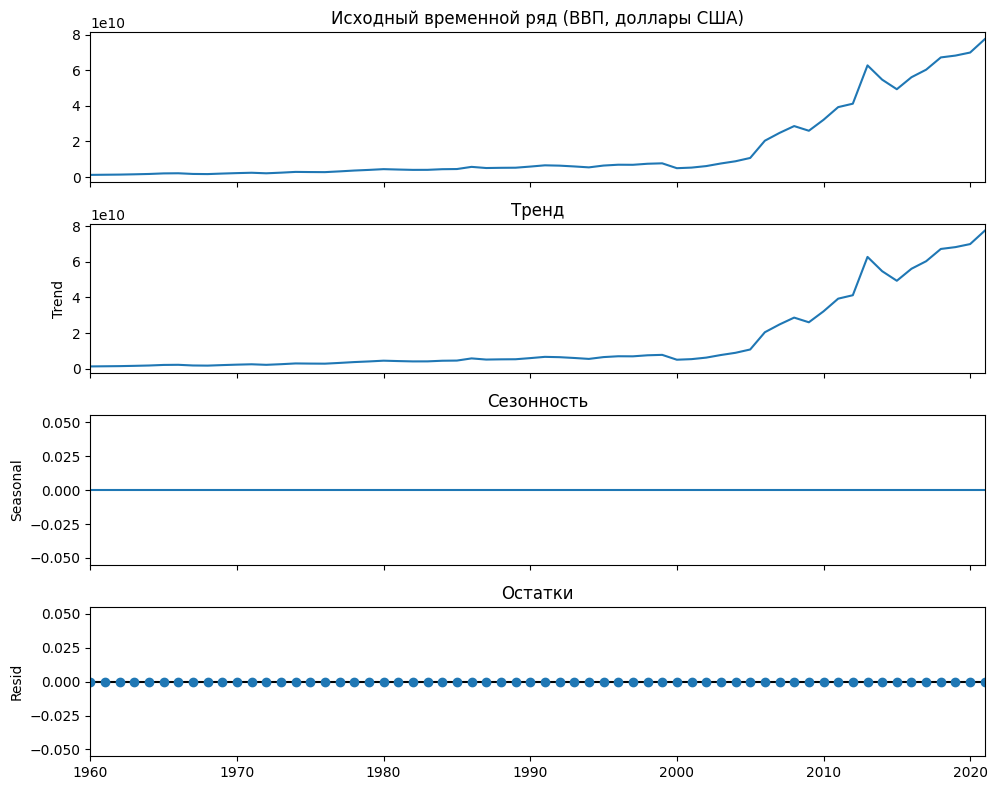

In [19]:
# Разложим временной ряд по ВВП на компоненты (тренд, сезонность и остаток) с использованием аддитивной модели
decomposition = seasonal_decompose(df['GDP (current US$)'], model='additive')

# Построим графики для визуализации разложения на компоненты
fig = decomposition.plot()
fig.set_size_inches(10, 8)
fig.axes[0].set_title('Исходный временной ряд (ВВП, доллары США)')
fig.axes[1].set_title('Тренд')
fig.axes[2].set_title('Сезонность')
fig.axes[3].set_title('Остатки')

plt.tight_layout()
plt.show()

**Выводы:**<br>
На графике заметен чётко выраженный тренд роста ВВП Ганы с течением времени. Особенно значительный рост наблюдается после 2000 года.
Также можно отметить:
1. Отсутствие сезонности, так как данные представлены в годовом разрезе, сезонные колебания не выявляются;
2. Менее выраженные колебания ВВП до 2000 года.

Далее согласно заданию отложим последние три года данных (2019–2021) как тестовую выборку и продолжим анализ на тренировочном подмножестве.

In [20]:
# Отложим последние 3 года как тестовую выборку
train_ghana = df.iloc[:-3]
test_ghana = df.iloc[-3:]

train_ghana.tail(), test_ghana.head()

(            GDP (current US$)
 year                         
 2014-01-01       5.478285e+10
 2015-01-01       4.940657e+10
 2016-01-01       5.616517e+10
 2017-01-01       6.040638e+10
 2018-01-01       6.729928e+10,
             GDP (current US$)
 year                         
 2019-01-01       6.833754e+10
 2020-01-01       7.004320e+10
 2021-01-01       7.759428e+10)

In [21]:
train_ghana.shape, test_ghana.shape

((59, 1), (3, 1))

## 2. Простое скользящее среднее (SMA)

**2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.<br>
Пример: train_df.spx.rolling(window=2).mean().<br>
Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.**

Построим график скользящего среднего для окна в 3 года, используя метод rolling(), который принимает в качестве параметра размер окна

In [22]:
# Устанавливаем библиотеку Kaleido для сохранения графиков Plotly в виде изображений
!pip install -U kaleido

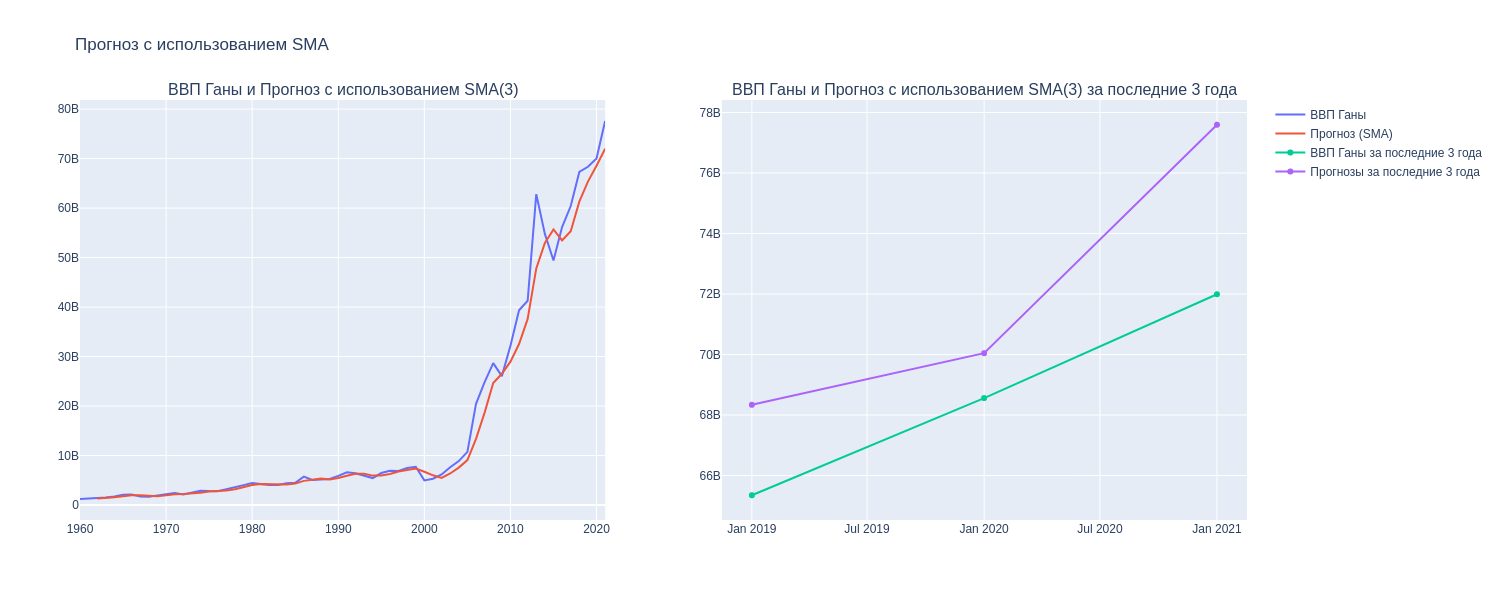

In [23]:
# Создаем два подграфика
fig = make_subplots(rows=1, cols=2, subplot_titles=['ВВП Ганы и Прогноз с использованием SMA(3)', 'ВВП Ганы и Прогноз с использованием SMA(3) за последние 3 года'])

# Добавляем график для исходного ВВП Ганы и прогнозируемого значения на основе SMA(3) для всего временного ряда
fig.add_trace(go.Scatter(y=df['GDP (current US$)'], x=df.index, showlegend=True, name='ВВП Ганы'), row=1, col=1)
fig.add_trace(go.Scatter(y=df['GDP (current US$)'].rolling(window=3).mean(), x=df.index, showlegend=True, name='Прогноз (SMA)'), row=1, col=1)

# Добавляем график для ВВП Ганы за последние 3 года и прогнозируемых значений на основе SMA(3) за тот же период
fig.add_trace(go.Scatter(y=df['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':], x=test_ghana.index, showlegend=True, name='ВВП Ганы за последние 3 года'), row=1, col=2)
fig.add_trace(go.Scatter(y=df['GDP (current US$)'].loc['2019-01-01':], x=test_ghana.index, showlegend=True, name='Прогнозы за последние 3 года'), row=1, col=2)

# Обновляем параметры графика
fig.update_layout(
    height=600,  # Высота графика
    width=1500,  # Ширина графика
    title_text='Прогноз с использованием SMA',
)
fig.show()

Вычислим метрики для модели, используя показатели MAPE и MSE:

In [24]:
MAPE = round(mean_absolute_percentage_error(test_ghana, df['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':])*100, 2)
MSE = round(mean_squared_error(test_ghana, df['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':])*100, 2)
print(f'MAPE for SMA = {MAPE}%')
print(f'MSE for SMA = {MSE}')

MAPE for SMA = 4.57%
MSE for SMA = 1.4175998301236838e+21


**Выводы:**<br>
По графикам "Прогноз с использованием SMA"  видно, что модель в большинстве случаев работает довольно хорошо, адекватно повторяя динамику ВВП Ганы. Для последних 3 лет метрика MAPE составила 4,57%, что указывает на высокую точность прогноза в этот период. Однако, модель плохо предсказывает моменты времени с резкими изменениями в значениях ВВП, такие как 2005-2009 гг и 2013-2015 гг, когда разброс значений значительно отличался от среднего. Это может свидетельствовать о нестационарности временного ряда, так как модель на основе скользящего среднего плохо справляется с резкими колебаниями.
Также стоит отметить, что модель SMA хорошо работает, когда в данных присутствует явный тренд, а также в случае стабильного тренда. Однако, она плохо справляется со сменой тренда, что снижает её эффективность при таких изменениях в данных.

## 3. Оценка стационарности временного ряда. Выбор модели ARMA/ARIMA

**3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. <br>
Примечание. <br>
Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.<br>
Параметры p и q выберите по коррелограммам ACF и PACF.<br>
Примечание.<br>
Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.<br>**

Проверим ряд на стационарность с помощью статистического теста Дики-Фуллера

In [25]:
# Применяем тест Дики-Фуллера к временным рядам
test = adfuller(train_ghana['GDP (current US$)'])

# Выводим статистику ADF, p-value и критические значения для разных уровней значимости
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

# Сравниваем статистику ADF с критическим значением на уровне 5%
if test[0]> test[4]['5%']: # если тестовая статистика больше критического значения для 5% значимости, то ряд нестационарен
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен') # если статистика меньше критического значения, ряд стационарен

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


Ряд нестационарен, поэтому производим его дифференцирование для приведения к стационарности и вновь проведём тест.

In [26]:
# Применяем второй порядок дифференцирования (разность между значениями, отстоящими на 2 периода)
df_diff= train_ghana.diff(periods=2).dropna()

# Выполняем тест Дики-Фуллера (ADF) для проверки стационарности преобразованного ряда.
test = adfuller(df_diff['GDP (current US$)'])

# Выводим статистику теста ADF
print('adf: ', test[0])  # Значение ADF-статистики
print('p-value: ', test[1])  # P-значение теста
print('Critical values: ', test[4])  # Критические значения на различных уровнях значимости

# Интерпретируем результат теста:
# Если ADF-статистика больше критического значения на уровне 5%, то ряд нестационарен.
# Иначе — ряд стационарен.
if test[0] > test[4]['5%']:
    print('ряд нестационарен')
else:
    print('ряд стационарен')

adf:  -3.999803440949154
p-value:  0.0014115408436661007
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


Только после применения второй разности ряд стал стационарным (d=2). <br)
Далее строим коррелограммы полную и частичную

In [27]:
# Создаем функцию для построения графиков автокорреляции (ACF) и частичной автокорреляции (PACF) временного ряда
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)

    # Строим автокорреляционную функцию (ACF)
    sgt.plot_acf(series, ax=axes[0], zero=False, lags=58)

    # Строим частичную автокорреляционную функцию (PACF)
    sgt.plot_pacf(series, ax=axes[1], method='yw', zero=False)
    plt.show()


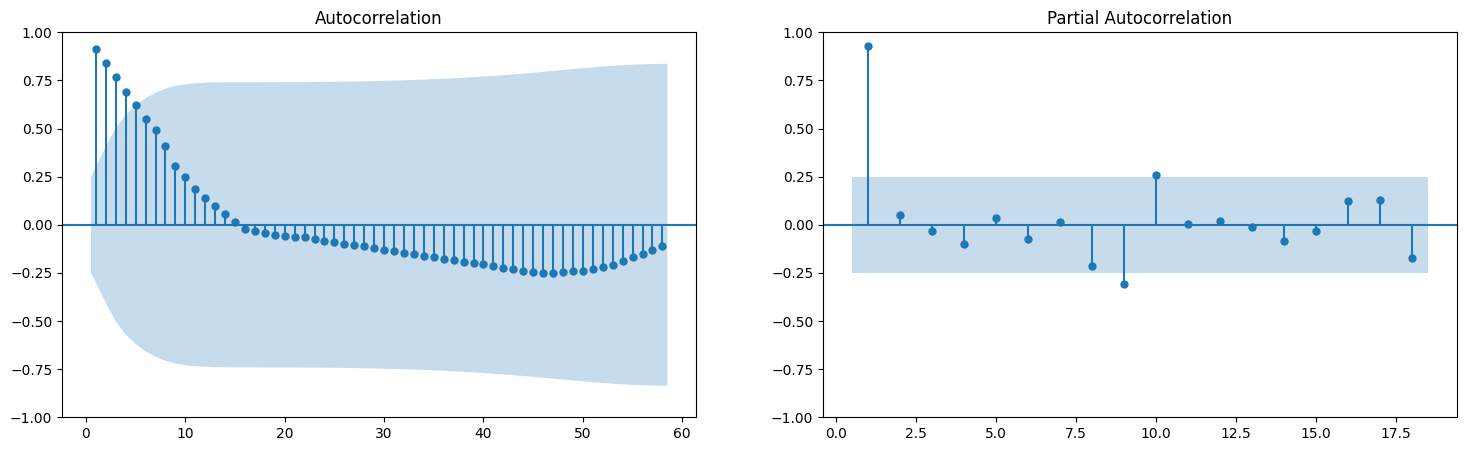

In [28]:
# Построение графиков автокорреляционной (ACF) и частной автокорреляционной (PACF) функций
# для временного ряда ВВП Ганы
plot_acf_pacf(df['GDP (current US$)'])

**Выводы:** <br>
На графике автокорреляции (ACF) чётко выделяется лаг под номером 1, что означает, что на этом лаге наблюдается сильная корреляция. А вот на графике частичной автокорреляции (PACF) также наблюдается сильная корреляция на лаге под номером 1.
Чтобы построить подходящую модель временного ряда, нужно правильно определить параметры, и в таких неоднозначных случаях удобно воспользоваться автоматическим подбором используя функция auto_arima из библиотеки pmdarima, которую мы и применим.

In [29]:
# Используем функцию auto_arima для автоматического подбора модели ARIMA с параметрами
smodel = pm.auto_arima(
    train_ghana, # входные данные (обучающий набор данных)
    start_p=1, # начальное значение для p (параметр AR)
    d=2, # порядок дифференцирования
    start_q=1, # начальное значение для q (параметр MA)
    max_p=3, # максимальное значение для p (параметр AR)
    max_q=3, # максимальное значение для q (параметр MA)
    test="adf", # тест для проверки стационарности (ADF - тест Дики-Фуллера)
    error_action="ignore",
    trace=True,
)
smodel.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.27 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]          
Total fit time: 1.160 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 30 Apr 2025   AIC                           2680.513
Time:                        06:03:22   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.02e+55. Standard errors may be unstable.
"""

**Вывод:**<br>


Согласно полученным результатам оптимальные параметры для построения модели ARIMA(1, 2, 3). Где: p = 1 количество лагов авторегрессии, d = 2 - порядок дифференцирования для стационарности, q = 3 порядок скользящего среднего.

## 4. Построение модели ARMA/ARIMA. Подбор наилучших параметров

**4. Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).
Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).**

**5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.**

**6. Сделайте выводы по полученным результатам.**

Строим модель ARIMA на оптимальных параметрах - ARIMA(1,2,3):

In [30]:
arima_model_opt = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Wed, 30 Apr 2025   AIC                           2680.513
Time:                        06:03:25   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.02e+55. Standard errors may be unstable.
"""

Выполним для неё предсказания:

In [31]:
# Cоздадим отдельный датафрейм с индексами первоначального
pred_df = pd.DataFrame(index = df.index)

# Сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# Перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = df.loc[test_ghana.index, 'GDP (current US$)']

# Формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05)  # Confidence level of 95%

# Добавим в датафрейм доверительный интервал для предсказанных значений
pred_df.loc[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.loc[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']

# Выводим последние 3 строки для проверки
pred_df.tail(3)


,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.781358e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10


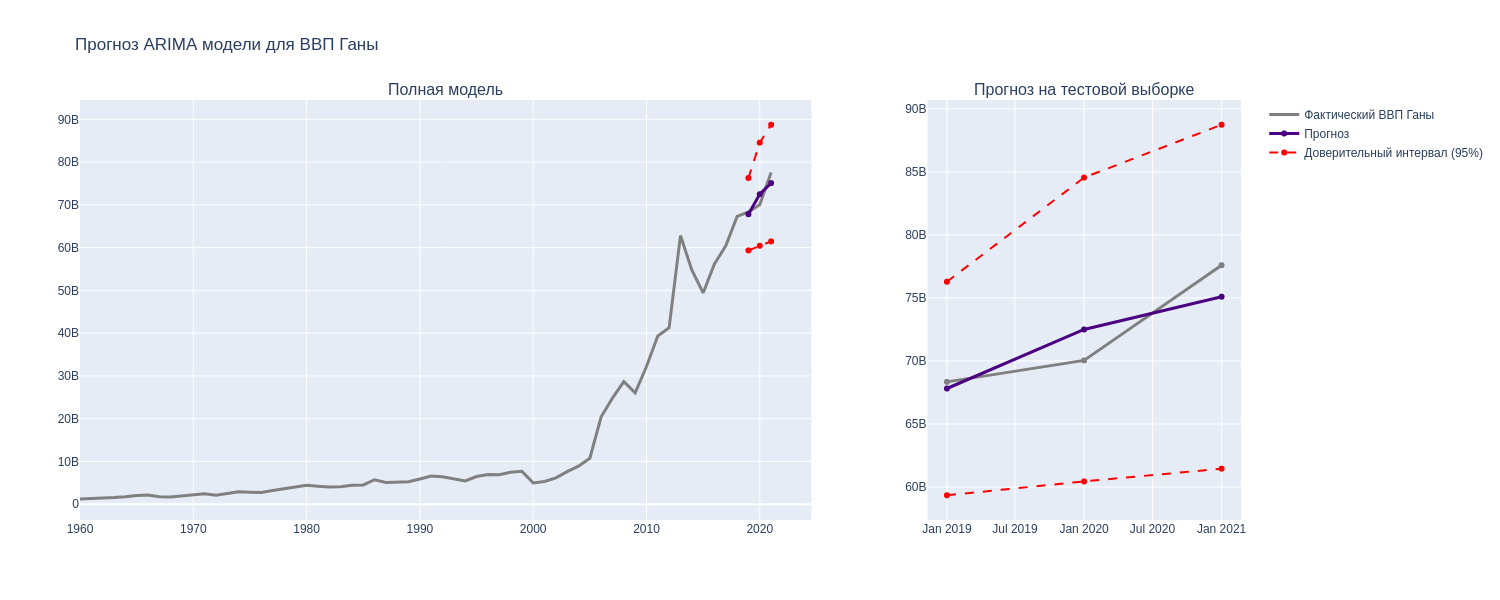

In [32]:
# Создаем сетку из двух графиков: один для полной модели, второй — для прогноза на тестовой выборке
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Полная модель', 'Прогноз на тестовой выборке'],
    column_widths=[0.7, 0.3]
)

# Левая панель - полная модель
# Добавляем фактические данные о ВВП Ганы для всей выборки
fig.add_trace(go.Scatter(
    y=df['GDP (current US$)'],
    x=df.index,
    showlegend=True,
    name='Фактический ВВП Ганы',
    line={'color': 'gray', 'width': 3}
), row=1, col=1)

# Добавляем предсказания модели ARIMA на полной выборке
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds'],
    x=test_ghana.index,
    showlegend=True,
    name='Прогноз',
    line={'color': 'indigo', 'width': 3}
), row=1, col=1)

# Добавляем нижнюю границу доверительного интервала на левой панели
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_lower'],
    x=test_ghana.index,
    showlegend=True,
    name='Доверительный интервал (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=1)

# Добавляем верхнюю границу доверительного интервала на левой панели
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_upper'],
    x=test_ghana.index,
    showlegend=False,
    name='Доверительный интервал (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=1)

# Правая панель - только тестовая выборка
# Добавляем фактические данные о ВВП Ганы для тестовой выборки
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['GDP (current US$)'],
    x=test_ghana.index,
    showlegend=False,
    name='Фактический ВВП Ганы',
    line={'color': 'gray', 'width': 3}
), row=1, col=2)

# Добавляем предсказания модели ARIMA для тестовой выборки
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds'],
    x=test_ghana.index,
    showlegend=False,
    name='Прогноз',
    line={'color': 'indigo', 'width': 3}
), row=1, col=2)

# Добавляем нижнюю границу доверительного интервала для тестовой выборки
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_lower'],
    x=test_ghana.index,
    showlegend=False,
    name='Нижняя граница доверительного интервала (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=2)

# Добавляем верхнюю границу доверительного интервала для тестовой выборки
fig.add_trace(go.Scatter(
    y=pred_df.loc[test_ghana.index]['model_preds_upper'],
    x=test_ghana.index,
    showlegend=False,
    name='Верхняя граница доверительного интервала (95%)',
    line={'color': 'red', 'width': 2, 'dash': 'dash'}
), row=1, col=2)

# Обновляем параметры оформления графика
fig.update_layout(
    height=600,
    width=1500,
    title_text='Прогноз ARIMA модели для ВВП Ганы'
)

fig.show()

In [33]:
df.tail(3)

,GDP (current US$)
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


Вычислим метрики для модели, используя показатели MAPE и MSE:

In [34]:
MAPE = round(mean_absolute_percentage_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
MSE = round(mean_squared_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
print(f'MAPE for ARIMA = {MAPE}%')
print(f'MSE for ARIMA = {MSE}')

MAPE for ARIMA = 2.5%
MSE for ARIMA = 4.1789564432466516e+20


**Выводы**:<br>
Модель ARIMA с оптимально подобранными параметрами показала следующие результаты:
- MAPE for ARIMA = 2.5% (MAPE for SMA = 4.57%)
- MSE for ARIMA = 4.1789564506037846e+20 (MSE for SMA = 1.4175998301236838e+21)
- AIC = 2680.513<br>

Как видно модель ARIMA показывает гораздо лучшие результаты, чем простое скользящее среднее: ошибка в процентах (MAPE) почти в 2 раза меньше и MSE(абсолютная ошибка) тоже значительно ниже.<br>
Метрика AIC помогает выбрать лучшую модель среди нескольких. Чем ниже AIC, тем лучше модель описывает данные с учётом сложности (числа параметров).
Однако стоит отметить, что SMA (Simple Moving Average) не имеет явно подбираемых параметров, как в ARIMA, поэтому расчёт AIC для модели SMA может быть менее информативным в сравнении с более сложными моделями.<br>
Также стоит отметить, что график предсказаний выглядит несколько приподнятым относительно фактических данных. Возможно, это удастся исправить в дальнейшем, применив методы, учитывающие изменение дисперсии во времени.

**Согласно заданию построим несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC**

**1. Строим модель ARIMA на параметрах - ARIMA(2,2,3)**

In [35]:
arima_model_223 = ARIMA(train_ghana, order = (2, 2, 3))
arima_model_223_fit = arima_model_223.fit()
arima_model_223_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -1335.196
Date:                Wed, 30 Apr 2025   AIC                           2682.393
Time:                        06:03:27   BIC                           2694.651
Sample:                    01-01-1960   HQIC                          2687.157
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4737      0.326     -1.454      0.146      -1.112       0.165
ar.L2          0.0894      0.336      0.266      0.790      -0.569       0.748
ma.L1         -0.4973      0.414     -1.202      0.229      -1.308       0.313
ma.L2         -0.8234      0.226     -3.645      0.000      -1.266      -0.381
ma.L3          0.5924      0.300      1.972      0.049       0.004       1.181
sigma2      1.862e+19   1.53e-20   1.22e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               182.02
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             443.52   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.27e+54. Standard errors may be unstable.
"""

**2. Строим модель ARIMA на параметрах - ARIMA(1,2,4)**

In [36]:
arima_model_124 = ARIMA(train_ghana, order = (1, 2, 4))
arima_model_124_fit = arima_model_124.fit()
arima_model_124_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 4)   Log Likelihood               -1335.308
Date:                Wed, 30 Apr 2025   AIC                           2682.617
Time:                        06:03:27   BIC                           2694.875
Sample:                    01-01-1960   HQIC                          2687.381
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6092      0.411     -1.481      0.139      -1.415       0.197
ma.L1         -0.3683      0.429     -0.858      0.391      -1.210       0.473
ma.L2         -0.8707      0.440     -1.979      0.048      -1.733      -0.008
ma.L3          0.4840      0.258      1.874      0.061      -0.022       0.990
ma.L4          0.0596      0.382      0.156      0.876      -0.689       0.808
sigma2      1.878e+19    2.3e-20   8.18e+38      0.000    1.88e+19    1.88e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               182.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             441.48   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.64e+54. Standard errors may be unstable.
"""

**3. Строим модель ARIMA на параметрах - ARIMA(0,2,3)**

In [37]:
arima_model_023 = ARIMA(train_ghana, order = (0, 2, 3))
arima_model_023_fit = arima_model_223.fit()
arima_model_023_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -1335.196
Date:                Wed, 30 Apr 2025   AIC                           2682.393
Time:                        06:03:28   BIC                           2694.651
Sample:                    01-01-1960   HQIC                          2687.157
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4737      0.326     -1.454      0.146      -1.112       0.165
ar.L2          0.0894      0.336      0.266      0.790      -0.569       0.748
ma.L1         -0.4973      0.414     -1.202      0.229      -1.308       0.313
ma.L2         -0.8234      0.226     -3.645      0.000      -1.266      -0.381
ma.L3          0.5924      0.300      1.972      0.049       0.004       1.181
sigma2      1.862e+19   1.53e-20   1.22e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               182.02
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             443.52   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.27e+54. Standard errors may be unstable.
"""

**Выводы:**<br>
Модель ARIMA с параметрами, ближайшими к найденным p и q показала следующие результаты:
- AIC_223 = 2682.393
- AIC_124 = 2682.617
- AIC_023 = 2682.393 <br>

Как видно модель ARIMA с оптимально подобранными параметрами показала лучший результат AIC_опт_парам = 2680.513

## 5. Предсказание волатильности. Модели прогнозирования гетероскедастичности. Prophet

**Предсказание волатильности. Модели прогнозирования гетероскедастичности**

Рассчитаем волатильность временного ряда ВВП как абсолютное значение процентного изменения по годам и добавим эти данные в исходный датафрейм в виде нового столбца GDP_vol

In [38]:
df['GDP_vol'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df['GDP_vol'].head()

,GDP_vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636


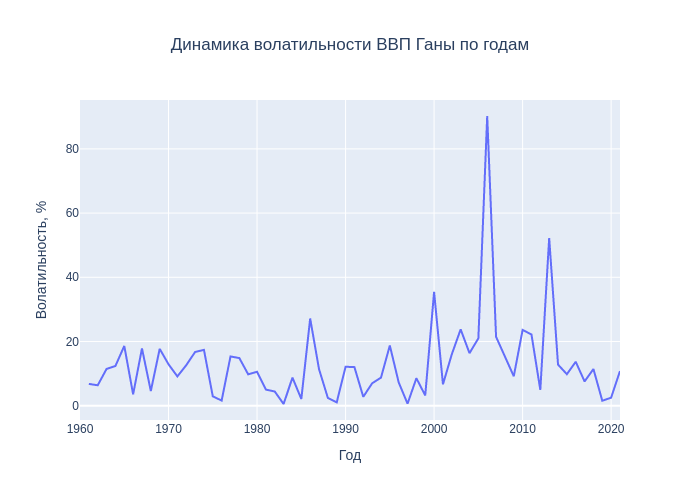

In [39]:
fig = px.line(x=df.index, y=df['GDP_vol'],
              labels={'x': 'Год', 'y': 'Волатильность, %'},
              title='Динамика волатильности ВВП Ганы по годам')
fig.update_layout(title_x=0.5)
fig.show()

In [40]:
import scipy.signal as signal

# Находим локальные максимумы (пики) на графике 'Динамика волатильности ВВП Ганы по годам'
peaks, _ = signal.find_peaks(df['GDP_vol'])
# Извлекаем значения пиков
peak_values = df['GDP_vol'].iloc[peaks].round(0)
print("Значения пиков:", peak_values)

Значения пиков: year
1965-01-01    19.0
1967-01-01    18.0
1969-01-01    18.0
1974-01-01    17.0
1977-01-01    15.0
1980-01-01    11.0
1984-01-01     9.0
1986-01-01    27.0
1990-01-01    12.0
1995-01-01    19.0
1998-01-01     9.0
2000-01-01    35.0
2003-01-01    24.0
2006-01-01    90.0
2010-01-01    24.0
2013-01-01    52.0
2016-01-01    14.0
2018-01-01    11.0
Name: GDP_vol, dtype: float64


Сначала проверим временной ряд на наличие гетероскедастичности, то есть неоднородности наблюдений, проявляющейся в изменении дисперсии со временем. Для этого создадим вспомогательный признак GDP_vol_sqr, содержащий квадраты значений волатильности, и визуализируем его на графике

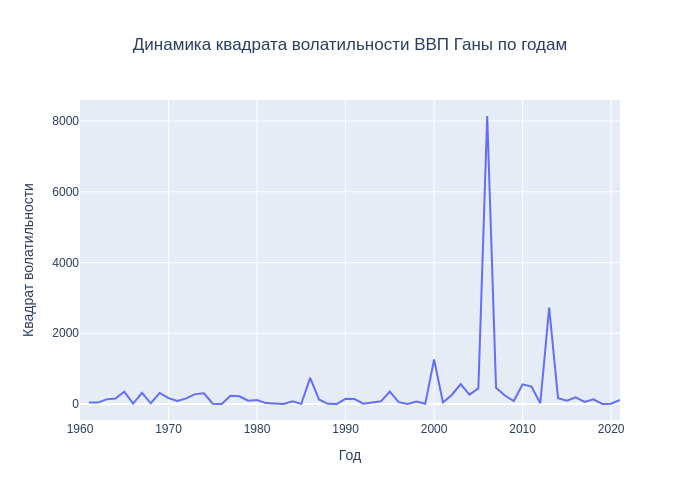

In [41]:
df['GDP_vol_sqr'] = df['GDP_vol'].apply(lambda x: x**2)

fig = px.line(x=df.index, y=df['GDP_vol_sqr'],
              labels={'x': 'Год', 'y': 'Квадрат волатильности'},
              title='Динамика квадрата волатильности ВВП Ганы по годам')
fig.update_layout(title_x=0.5)
fig.show()

**Выводы:** <br>
Согласно полученному графику 'Динамика волатильности ВВП Ганы по годам' характеризуется на всём своём периоде наблюдения стабильной волатильностью в коридоре 20% (особенно в период 1960-1999) с выделением нескольких резких пиков:

- 1986 - в 27%
- 2000 - в 35%
- 2006 - в 90%
- 2013 - в 52%

График 'Динамика квадрата волатильности ВВП Ганы по годам' указывает на гомоскедастичность временного ряда, т.к значения показателя в основном близки к нулю на всём протяжении, за исключением отдельных ранее отмеченных пиков.

Далее вновь разобьём данные на тестовые и тренировочные и выполним декомпозицию временного ряда:

In [42]:
train_ghana = df.loc[:'2018-12-31']
test_ghana = df.loc['2019-01-01':]
train_ghana.shape, test_ghana.shape

((59, 3), (3, 3))

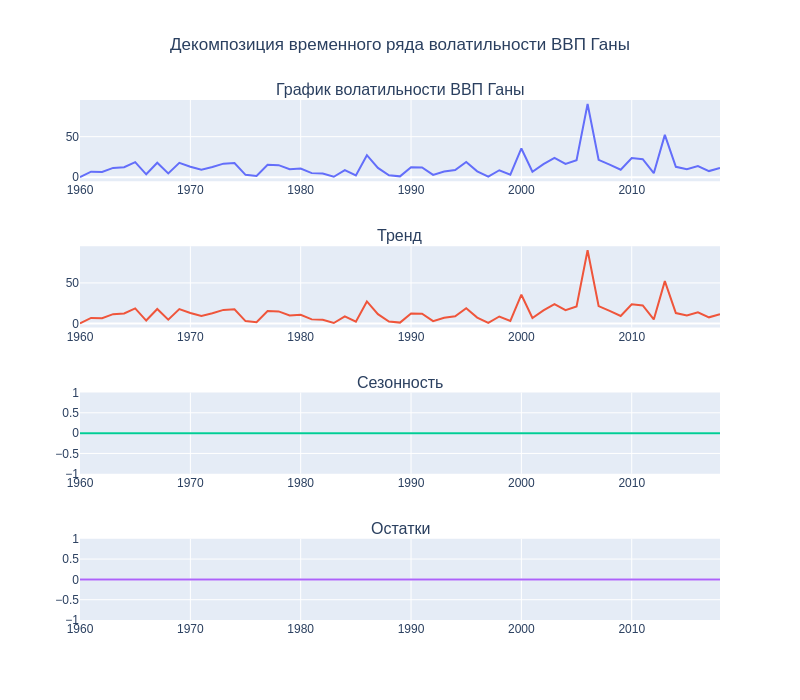

In [43]:
# Выполняем декомпозицию временного ряда волатильности на тренд, сезонность и остатки
result = seasonal_decompose(train_ghana['GDP_vol'].fillna(0), model='additive')

# Создаём график с 4 подграфиками: исходный ряд, тренд, сезонность и остатки
fig = make_subplots(
    rows=4, cols=1,
    row_heights=[50, 50, 50, 50],
    subplot_titles=[
        'График волатильности ВВП Ганы',
        'Тренд',
        'Сезонность',
        'Остатки'
    ]
)

fig.add_trace(go.Scatter(y=train_ghana['GDP_vol'].fillna(0), x=train_ghana.index, showlegend=False), row=1, col=1) # Добавляем исходный временной ряд
fig.add_trace(go.Scatter(y=result.trend, x=train_ghana.index, showlegend=False), row=2, col=1) # Добавляем компонент тренда
fig.add_trace(go.Scatter(y=result.seasonal, x=train_ghana.index, showlegend=False), row=3, col=1) # Добавляем компонент сезонности
fig.add_trace(go.Scatter(y=result.resid, x=train_ghana.index, showlegend=False), row=4, col=1) # Добавляем остатки

# Обновляем оформление графика
fig.update_layout(
    height=700,
    width=800,
    title_text='Декомпозиция временного ряда волатильности ВВП Ганы',
    title_x=0.5
)

fig.show()

**Выводы:**<br>
Декомпозиция временного ряда показала чётко выраженный тренд роста ВВП Ганы с течением времени. Особенно значительный рост наблюдается после 2000 года.
Также можно отметить:
1. Отсутствие сезонности, так как данные представлены в годовом разрезе, сезонные колебания не выявляются;
2. Менее выраженные колебания ВВП до 2000 года.

Построим коррелограммы волатильности:

In [44]:
# Создадим функцию для построения графиков автокорреляции (ACF) и частичной автокорреляции (PACF)
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    # График автокорреляционной функции (ACF)
    sgt.plot_acf(series, ax=axes[0], zero=False, lags=57)
    axes[0].set_title("График автокорреляции (ACF)")
    axes[0].set_xlabel("Лаг")
    axes[0].set_ylabel("Автокорреляция")

    # График частичной автокорреляционной функции (PACF)
    sgt.plot_pacf(series, ax=axes[1], method='yw', zero=False)
    axes[1].set_title("График частичной автокорреляции (PACF)")
    axes[1].set_xlabel("Лаг")
    axes[1].set_ylabel("Частичная автокорреляция")

    plt.show()

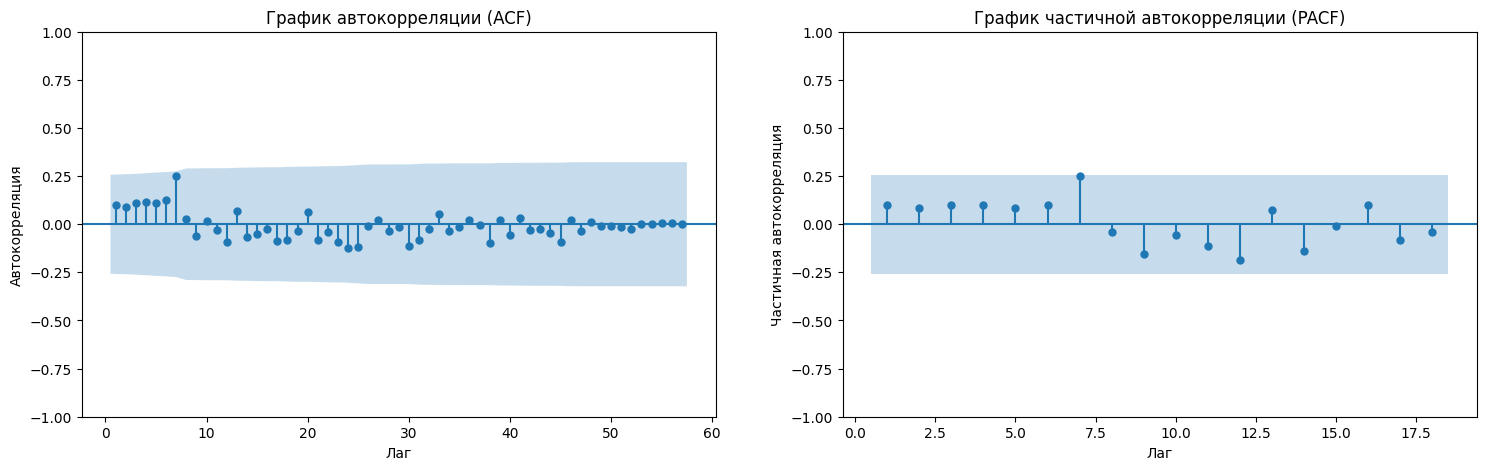

In [45]:
plot_acf_pacf(train_ghana['GDP_vol'][1:])

**Вывод:**<br>
На графиках коррелограмм видно практически отсутствующую корреляцию со слабо выделяющимся седьмым лагом.


Проверим ряд на стационарность.

In [46]:
# Применяем тест Дики-Фуллера к временным рядам
test = adfuller(train_ghana['GDP_vol'][1:])

# Выводим статистику ADF, p-value и критические значения для разных уровней значимости
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

# Сравниваем статистику ADF с критическим значением на уровне 5%
if test[0]> test[4]['5%']: # если тестовая статистика больше критического значения для 5% значимости, то ряд нестационарен
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен') # если статистика меньше критического значения, ряд стационарен

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Ряд стационарен


**Вывод:**<br>
Ряд стационарен.

Используем GARCH-модель для предсказания волатильности.

In [47]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.9 MB/s eta 0:00:00


In [48]:
# Мы хотим сохранить полный объём данных, включая индексы, поэтому используем весь датасет,
# который содержит как обучающую (train), так и тестовую (test) выборки
df = pd.DataFrame(df['GDP_vol'].loc[df.index])

from arch import arch_model

# Инициализируем модель GARCH(7,1) с использованием выбранного временного ряда
model = arch_model(df['GDP_vol'].dropna(), p=7, q=1, vol="GARCH")

# Задаём границу, до которой модель будет обучаться
model_results = model.fit(last_obs=test_ghana.index[0], update_freq=5)

# Выводим сводку результатов обучения модели
model_results.summary()

Iteration:      5,   Func. Count:     64,   Neg. LLF: 227.55844185756527
Iteration:     10,   Func. Count:    122,   Neg. LLF: 214.28338052102296
Iteration:     15,   Func. Count:    177,   Neg. LLF: 213.57945016052307
Iteration:     20,   Func. Count:    232,   Neg. LLF: 213.5726263463793
Iteration:     25,   Func. Count:    287,   Neg. LLF: 213.55075109473492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 213.5507470737459
            Iterations: 27
            Function evaluations: 308
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -213.551
Distribution:                  Normal   AIC:                           447.101
Method:            Maximum Likelihood   BIC:                           467.706
                                        No. Observations:                   58
Date:                Wed, Apr 30 2025   Df Residuals:                       57
Time:                        06:03:39   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.0952      0.833     13.322  1.730e-40 [  9.463, 12.728]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         24.5309     15.324      1.601      0.109      [ -5.504, 54.566]
alpha[1]   1.1357e-09  4.702e-03  2.415e-07      1.000 [-9.216e-03,9.216e-03]
alpha[2]   1.7557e-10  1.594e-02  1.102e-08      1.000 [-3.123e-02,3.123e-02]
alpha[3]       0.3634      0.315      1.155      0.248      [ -0.253,  0.980]
alpha[4]   3.8344e-04      0.121  3.174e-03      0.997      [ -0.236,  0.237]
alpha[5]   1.2546e-11  7.455e-03  1.683e-09      1.000 [-1.461e-02,1.461e-02]
alpha[6]       0.5534      0.387      1.430      0.153      [ -0.205,  1.312]
alpha[7]       0.0829      0.229      0.362      0.717      [ -0.366,  0.531]
beta[1]    1.0826e-10      0.338  3.200e-10      1.000      [ -0.663,  0.663]
=============================================================================

Covariance estimator: robust
"""

Сделаем предсказания и визуализируем результат.

In [49]:
predictions_df = test_ghana.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_ghana.index]

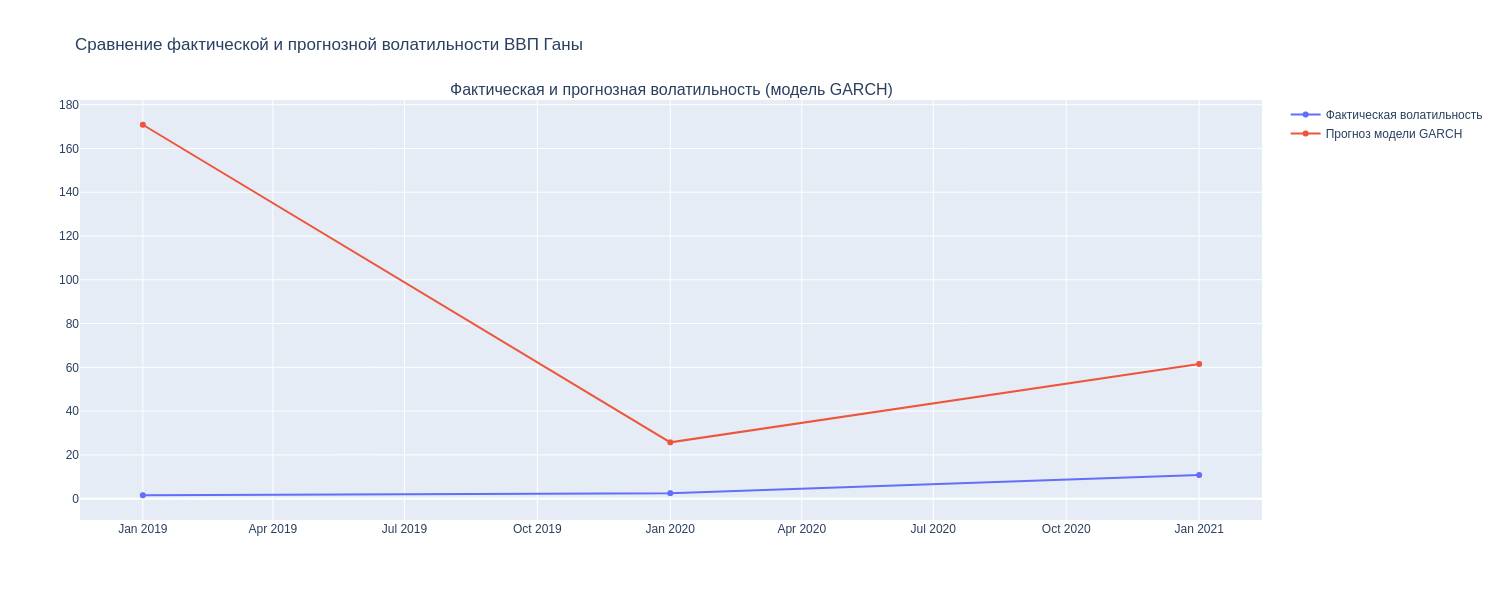

In [50]:
fig = make_subplots(rows=1, cols=1, subplot_titles=['Фактическая и прогнозная волатильность (модель GARCH)'])

fig.add_trace(go.Scatter(
    y=predictions_df["GDP_vol"].abs(),
    x=test_ghana.index,
    showlegend=True,
    name='Фактическая волатильность'
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=predictions_df["Predictions"],
    x=test_ghana.index,
    showlegend=True,
    name='Прогноз модели GARCH'
), row=1, col=1)

fig.update_layout(
    height=600,
    width=1500,
    title_text='Сравнение фактической и прогнозной волатильности ВВП Ганы'
)

fig.show()


Вычислим метрики для модели, используя показатели MAPE и MSE:

In [51]:
MAPE = round(mean_absolute_percentage_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])*100, 2)
MSE = round(mean_squared_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])*100, 2)
print(f'MAPE for GARCH = {MAPE}%')
print(f'MSE for GARCH = {MSE}')

MAPE for GARCH = 4124.97%
MSE for GARCH = 1059184.99


Теперь сделаем модель на основе линейной регрессии:

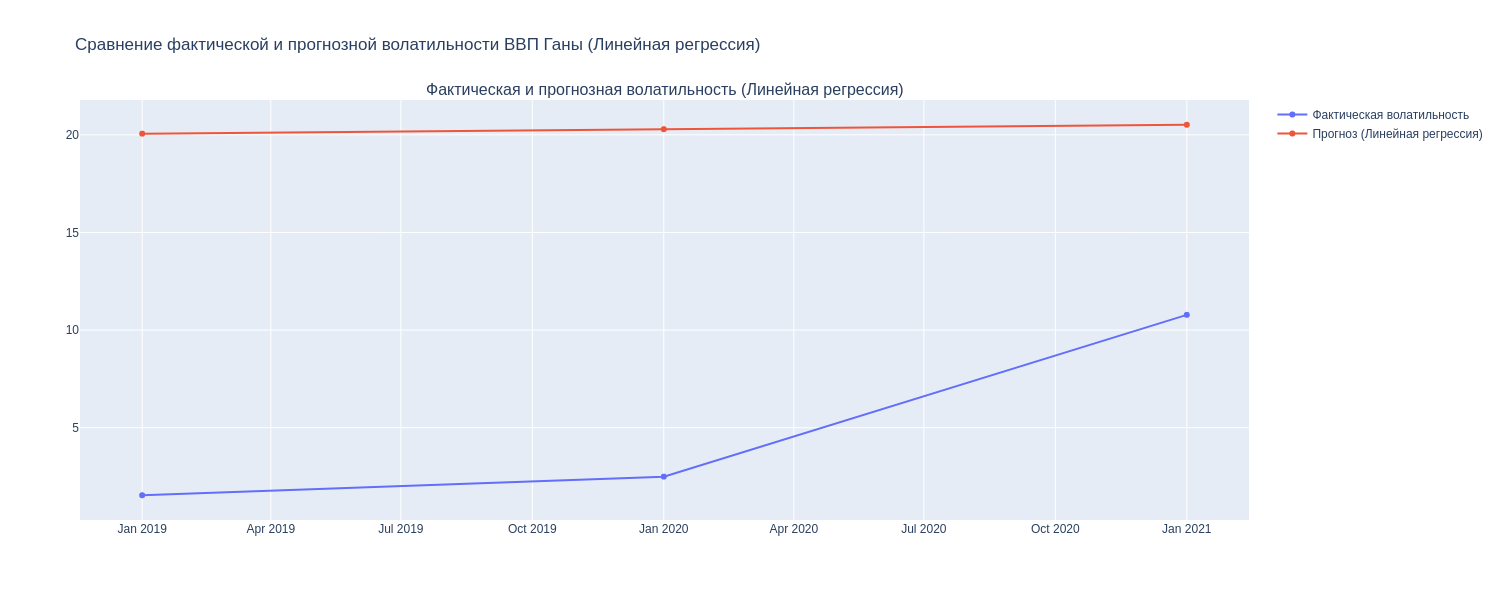

In [52]:
# Создаём тренировочную выборку X_train и тестовую X_test как последовательность индексов
X_train = pd.DataFrame(range(df['GDP_vol'].shape[0]))[:train_ghana.shape[0]].fillna(0)
X_test = pd.DataFrame(range(df['GDP_vol'].shape[0]))[train_ghana.shape[0]:].fillna(0)

# Целевые переменные: волатильность ВВП для тренировочной и тестовой выборок
y_train = train_ghana['GDP_vol'].fillna(0)
y_test = test_ghana['GDP_vol'].fillna(0)

# Обучаем модель линейной регрессии
lr = LinearRegression()
lr.fit(X_train, y_train)

# Делаем прогноз на тестовой выборке
lr_predict = lr.predict(X_test)

# Строим график фактической и предсказанной волатильности
fig = make_subplots(rows=1, cols=1, subplot_titles=['Фактическая и прогнозная волатильность (Линейная регрессия)'])

fig.add_trace(go.Scatter(
    y=y_test,
    x=y_test.index,
    showlegend=True,
    name='Фактическая волатильность'
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=lr_predict,
    x=y_test.index,
    showlegend=True,
    name='Прогноз (Линейная регрессия)'
), row=1, col=1)

fig.update_layout(
    height=600,
    width=1500,
    title_text='Сравнение фактической и прогнозной волатильности ВВП Ганы (Линейная регрессия)'
)

fig.show()


Вычислим метрики для модели, используя показатели MAPE и MSE:

In [53]:
MAPE = round(mean_absolute_percentage_error(y_test, lr_predict)*100, 2)
MSE = round(mean_squared_error(y_test, lr_predict)*100, 2)
print(f'MAPE for LinearRegression_Volatility= {MAPE}%')
print(f'MSE for LinearRegression_Volatility = {MSE}')

MAPE for LinearRegression_Volatility= 667.81%
MSE for LinearRegression_Volatility = 25140.89


**Выводы:**<br>
На основании полученного графика можно сделать вывод, что модель GARCH не продемонстрировала удовлетворительного качества прогноза. Вероятной причиной является отсутствие аналогичных колебаний дисперсии в обучающей выборке, в результате чего модель не смогла адаптироваться к новой структуре данных. Кроме того, предварительный анализ показал, что исследуемый временной ряд является гомоскедастичным, демонстрируя относительно стабильную дисперсию на всём протяжении наблюдений, за исключением четырёх выбросов. Поскольку модель GARCH ориентирована на моделирование и прогнозирование временно изменяющейся (гетероскедастичной) дисперсии, её применение в данном случае оказалось неэффективным. Это подтверждается и количественными метриками: модель уступила по точности даже линейной регрессии, чьи показатели оказались намного лучше.

**Prophet**

Модель **Prophet** предназначена для прогнозирования временных рядов с выраженной сезонностью: годовой, еженедельной и ежедневной и учитывает также эффекты праздников. <br>
**Prophet** показывает наилучшие результаты, когда:
* временной ряд обладает регулярными сезонными паттернами;
* данные охватывают несколько сезонов;
* возможны пропуски и выбросы в данных.

В нашем случае данные по ВВП Ганы являются несезонными, так как ВВП рассчитывается раз в год и не демонстрирует регулярных колебаний, связанных с временами года или праздничными периодами.

Поэтому использование Prophet для прогнозирования ВВП на годовом уровне является нецелесообразным, так как он не сможет использовать свои ключевые преимущества(работу с сезонностью и праздничными эффектами).

**Заключение**:<br>
Таким образом, наилучшей моделью для прогнозирования ВВП Ганы стала ARIMA(1,2,3), построенная на предварительно обработанном и интерполированном временном ряде. Эта модель наилучшим образом справилась с задачей прогнозирования благодаря учету тренда и отсутствию необходимости моделировать сезонные колебания.